In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import ast
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.cm as cm
from movie_genre_tangles.convenience import *
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [4]:
seps, sepidtokeyword = csv_to_setseperationsystem('../data/data_F10.csv')
with open('../orders/orders_O12_K10', 'rb') as f:
    order_O12 = pickle.load(f)
lvltokeyword = [sepidtokeyword[x] for x in np.argsort(order_O12)[:650]]
with open('../results/interesting_umbrella_tm_K10.pkl', 'rb') as f:
    interesting_umbrella_tm = pickle.load(f)
oriented_seps = seps[:,np.argsort(order_O12)[:650]]

Checks if any level is associated with more than one keyword:

In [5]:
np.any([len(x) > 1 for x in lvltokeyword])

False

Plots the matrix containing the interesting umbrella tangles:

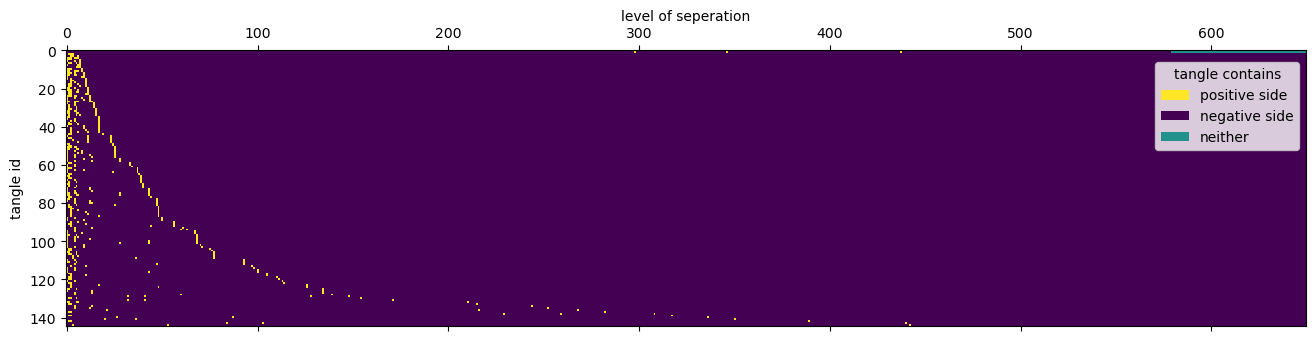

In [9]:
cmap = plt.get_cmap('viridis')
legend_elements = [
    Patch(facecolor=cmap(1.0), label='positive side'),
    Patch(facecolor=cmap(0.0), label='negative side'),
    Patch(facecolor=cmap(0.5), label='neither'),
]

plt.matshow(interesting_umbrella_tm)
plt.gca().set_aspect('auto')
plt.gca().xaxis.set_label_position('top')
plt.xlabel('level of seperation')
plt.ylabel('tangle id')
plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.98), title = 'tangle contains')
plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/tm_entropy_K10.png', bbox_inches='tight')

Plots for each level the percentage of tangles containing the assoziated keyword:

Text(0, 0.5, 'proportion of tangles chosing $\\vec{k}$')

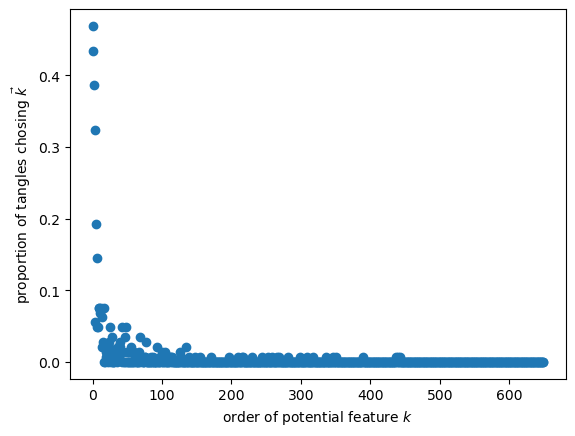

In [11]:
plt.scatter(range(interesting_umbrella_tm.shape[1]),((interesting_umbrella_tm == 1).sum(axis = 0) / interesting_umbrella_tm.shape[0]))
plt.xlabel(r'order of potential feature $k$')
plt.ylabel(r'proportion of tangles chosing $\vec{k}$')
#plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/proportions_separations.png', bbox_inches='tight')

Counts the number of interessting umbrella tangles containing at least 1 and 2 keywords assosiated with one of the first 10 levels:

In [12]:
print(((interesting_umbrella_tm[:,:10] == 1).sum(axis = 1) >= 1).sum())
print(((interesting_umbrella_tm[:,:10] == 1).sum(axis = 1) >= 2).sum())

136
109


Prints all keywords, that are not contained in any tangle:

In [14]:
not_contained_keywords = [lvltokeyword[x] for x in np.where((interesting_umbrella_tm == 1).sum(axis = 0) == 0)[0]]
len(not_contained_keywords)

559

Calculates the core of each tangle and counts the tangles with less than 10 movies in its core:

In [16]:
cores = {}
for i in range(interesting_umbrella_tm.shape[0]):
    pos = np.where(interesting_umbrella_tm[i] == 1)[0]
    core = np.where(oriented_seps[:,pos].min(axis = 1) == 1)[0]
    cores[i] = core.size   
small_cores = [x for x in cores.keys() if cores[x] < 10]
len(small_cores)

46

Calculates corpora of the tangles and their sizes:

In [17]:
corpora = np.zeros((seps.shape[0], interesting_umbrella_tm.shape[0]))
for i in range(seps.shape[0]):
    match = (interesting_umbrella_tm[:,(oriented_seps[i] == 1)] == 1).sum(axis = 1)
    corpora[i, np.where(match >= 3)] = 1
corpora_sizes = (corpora == 1).sum(axis = 0)

Counts how many movies are in the corpus of at least one tangle:

In [ ]:
((corpora == 1).any(axis = 1)).sum()

1131

Calculates the first two principal componets of the matrix containing the interesting umbrella tangles:

In [18]:
pca = PCA(n_components= 2)
principal_components = pca.fit_transform(interesting_umbrella_tm)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

Finds the optimal number of clusters:

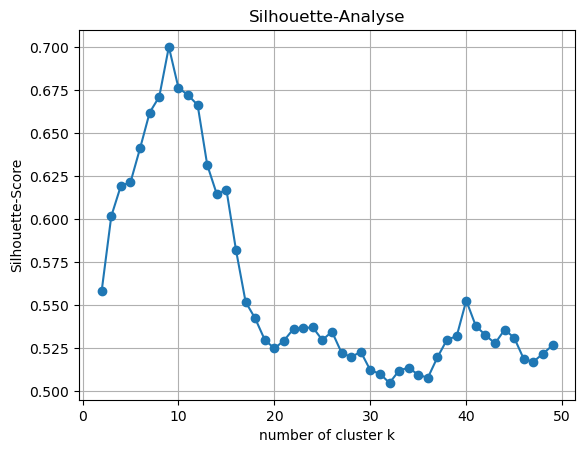

For 9 clusters we get the best average silhouette score of 0.7001461262418175


In [19]:
silhouette_scores = []
k_values = range(2, 50)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state = 42)
    kmeans.fit(pca_df[['PC1', 'PC2']])
    score = silhouette_score(pca_df[['PC1', 'PC2']], kmeans.labels_)
    silhouette_scores.append(score)
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('number of cluster k')
plt.ylabel('Silhouette-Score')
plt.title('Silhouette-Analyse')
plt.grid()
plt.show()

print("For", k_values[np.argmax(silhouette_scores)], "clusters we get the best average silhouette score of", np.max(silhouette_scores))

Clusters the Tangles and plots them:

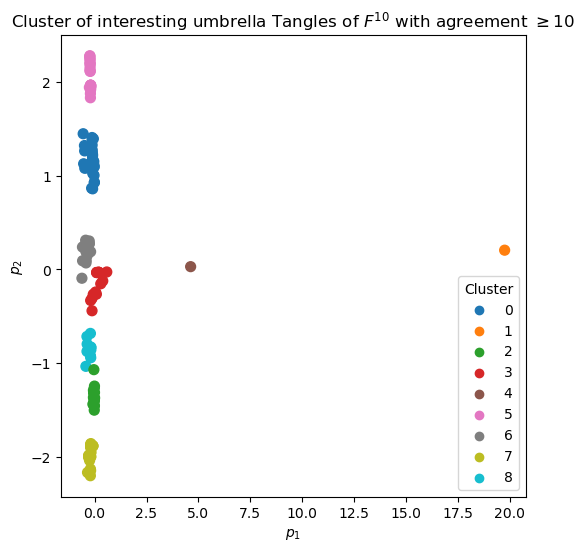

In [20]:
kmeans = KMeans(n_clusters=9, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

plt.figure(figsize=(6,6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap = cm.tab10, s=50)
plt.title(r'Cluster of interesting umbrella Tangles of $F^{10}$ with agreement $\geq 10$')
plt.xlabel('$p_1$')
plt.ylabel('$p_2$')

for i in range(9):
    plt.scatter([], [], c=[cm.tab10(plt.Normalize(0, 8)(i))], label=str(i))
plt.legend(title='Cluster', loc='best')
#plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/cluster_ag10.png', bbox_inches='tight')
plt.show()

Prints all tangles, sorted by cluster:

In [ ]:
for i in np.unique(pca_df['Cluster'].values):
    print('CLUSTER', i)
    for t in np.where(pca_df['Cluster'] == i)[0]:
        printkeywordsfromtm(interesting_umbrella_tm, t, lvltokeyword)

Chooses the tangle with largest corpus for each cluster as it's representative:

In [21]:
representatives = []
for i in np.unique(pca_df['Cluster'].values):
    print('CLUSTER', i)
    print('has ', (pca_df['Cluster'] == i).sum(), ' tangles')
    mask =  np.where(pca_df['Cluster'] != i)[0]
    masked_corpora = corpora_sizes.copy()
    masked_corpora[mask] = 0
    representative = np.argmax(masked_corpora)
    representatives.append(representative)
    printkeywordsfromtm(interesting_umbrella_tm, representative, lvltokeyword)
    print("corpus has size ", masked_corpora[representative])
    print("its core has size", cores[representative])

CLUSTER 0
has  30  tangles
tangle:  27
['murder']
['nudity']
['violence']
['female nudity']
['independent film']
['blood']
['gore']
corpus has size  293
its core has size 2
CLUSTER 1
has  1  tangles
tangle:  0
['gay']
['lgbt']
['homosexuality']
['gay relationship']
['gay man']
corpus has size  36
its core has size 12
CLUSTER 2
has  16  tangles
tangle:  43
['sex']
['independent film']
['teenager']
['drug']
corpus has size  44
its core has size 7
CLUSTER 3
has  16  tangles
tangle:  129
['superhero']
['based on comic']
['super powers']
['dc comics']
corpus has size  55
its core has size 20
CLUSTER 4
has  1  tangles
tangle:  1
['treasure']
['treasure hunt']
['archaeologist']
corpus has size  13
its core has size 13
CLUSTER 5
has  25  tangles
tangle:  25
['murder']
['violence']
['revenge']
['blood']
corpus has size  78
its core has size 6
CLUSTER 6
has  17  tangles
tangle:  4
['murder']
['nudity']
['sex']
['violence']
['female nudity']
['independent film']
corpus has size  325
its core has 

How many unique movies are in the corpora of the representatives?

In [22]:
(corpora[:,representatives].max(axis = 1) == 1).sum()

566

The following is the Greedy Genre Ranking Algorithm:

In [23]:
genres = []
genre_sizes = []
cc = corpora.copy()
#while 1 in cc:
for i in range(20): #used to stop after j steps
    next_genre = np.argmax(cc.sum(axis=0))
    genres.append(next_genre)
    genre_sizes.append(cc[:,next_genre].sum())
    cc[cc[:,next_genre] == 1] = 0
i = 1
for t in genres:
    printkeywordsfromtm(interesting_umbrella_tm, t, lvltokeyword)
    print(i, "-th genre contains", corpora_sizes[t], "movies")
    print("its core has size", cores[t])
    i +=1
    

tangle:  4
['murder']
['nudity']
['sex']
['violence']
['female nudity']
['independent film']
1 -th genre contains 325 movies
its core has size 3
tangle:  27
['murder']
['nudity']
['violence']
['female nudity']
['independent film']
['blood']
['gore']
2 -th genre contains 293 movies
its core has size 2
tangle:  129
['superhero']
['based on comic']
['super powers']
['dc comics']
3 -th genre contains 55 movies
its core has size 20
tangle:  23
['nudity']
['sex']
['love']
['teenager']
4 -th genre contains 81 movies
its core has size 7
tangle:  0
['gay']
['lgbt']
['homosexuality']
['gay relationship']
['gay man']
5 -th genre contains 36 movies
its core has size 12
tangle:  63
['murder']
['violence']
['police']
['detective']
6 -th genre contains 57 movies
its core has size 7
tangle:  131
['superhero']
['based on comic']
['marvel comic']
7 -th genre contains 35 movies
its core has size 35
tangle:  11
['murder']
['nudity']
['violence']
['female nudity']
['independent film']
['revenge']
8 -th gen

How many unique movies are in the corprora of the first 9 greedely chosen tangels?

In [24]:
(corpora[:,genres[:9]].max(axis = 1) == 1).sum()

661

Genre Matrixes:

In [26]:
data = pd.read_csv('../data/data_F10.csv')
data['keywords'] = data['keywords'].apply(lambda x: ast.literal_eval(x))
data["genres"] = data["genres"].apply(lambda x: ast.literal_eval(x))
len(data) == seps.shape[0]

True

In [27]:
np.sum([assigned_genres == [] for assigned_genres in data['genres']])

38

In [28]:
print(len(data))
data['genres'].explode().value_counts()

15567


genres
Drama              7759
Comedy             4509
Thriller           3665
Action             2894
Romance            2609
Horror             2339
Crime              2034
Adventure          1729
Science Fiction    1538
Mystery            1158
Fantasy            1110
Family             1048
Documentary         798
Animation           740
History             562
Music               553
War                 497
Western             352
Foreign             257
TV Movie            232
Name: count, dtype: int64

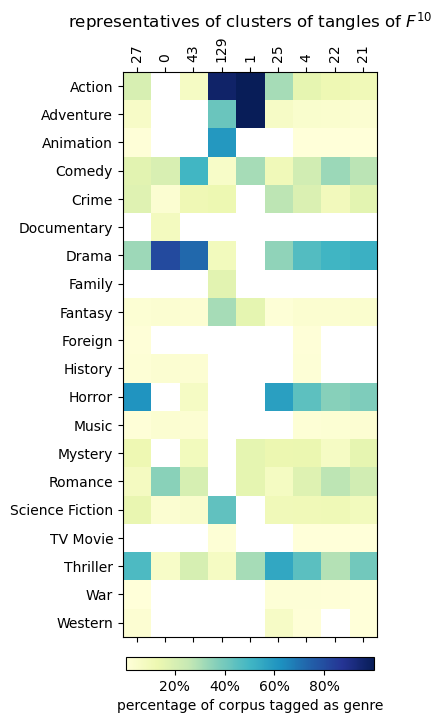

In [ ]:
fig = plot_genre_mat(data, corpora, representatives)
plt.title("representatives of clusters of tangles of $F^{10}$")
cbar = plt.colorbar(fig, orientation = "horizontal", pad = 0.03, shrink = 0.8)
cbar.set_label("percentage of corpus tagged as genre")
cbar.set_ticks(ticks=[0.2,0.4,0.6,0.8],labels= ["20%", "40%", "60%", "80%"])
#plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/genre_mat_cluster_10.png', bbox_inches='tight')

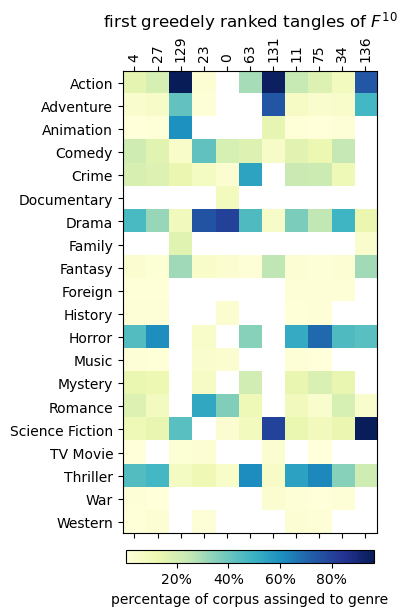

In [ ]:
fig = plot_genre_mat(data, corpora, genres[:11])
plt.title("first greedely ranked tangles of $F^{10}$")
cbar = plt.colorbar(fig, orientation = "horizontal", pad = 0.03, shrink = 0.8)
cbar.set_label("percentage of corpus assinged to genre")
cbar.set_ticks(ticks=[0.2,0.4,0.6,0.8],labels= ["20%", "40%", "60%", "80%"])
#plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/genre_mat_greedy_10.png', bbox_inches='tight')

Miscellanious calucaltions below:

Compares corpora of the two superhero movie tangles

In [34]:
print(data['original_title'][corpora[:,129] == 1])
print(data['original_title'][corpora[:,131] == 1])

104                                         Batman Forever
394                                                 Batman
859                                         Batman Returns
951                                         Batman & Robin
1647                                              Superman
1648                                           Superman II
1649                                          Superman III
1650                      Superman IV: The Quest for Peace
1999                          Batman: Mask of the Phantasm
5192                    Batman Beyond: Return of the Joker
5628                                         Batman Begins
6116                                      Superman Returns
6874                      Justice League: The New Frontier
6887                                       The Dark Knight
7562                           Green Lantern: First Flight
8057                            Batman: Under the Red Hood
8153                           Superman/Batman: Apocalyp

Are there sets of keywords with highly overlaping positive sides?

In [35]:
keyword_sims = np.zeros((650,650))
for i in range(650):
    for j in range(i):
        shared = (oriented_seps[oriented_seps[:,i] == 1,j] == 1).sum()
        keyword_sims[i,j] = shared / (oriented_seps[:,i] == 1).sum()
        keyword_sims[j,i] = shared / (oriented_seps[:,j] == 1).sum()
high_sim = np.where(keyword_sims > 0.5)

In [36]:
[i for i in high_sim[0] if i in high_sim[1]]

[128, 128, 148, 148, 148, 216, 216, 259, 268, 268, 308]

In [42]:
lvltokeyword[216]

['giant monster']

In [43]:
#there are tree tupels of keywords, that share over half the movies they were assigned to
print(lvltokeyword[128])
print(lvltokeyword[148])
print(lvltokeyword[259])
print(lvltokeyword[308])
print(lvltokeyword[216])
print(lvltokeyword[268])

['super powers']
['dc comics']
['stand-up comedy']
['comedian']
['giant monster']
['kaiju']


Prints the corpora of the representatives of the clusters:

In [ ]:
for i in range(10):
    print("The corpus of the representative of cluster", i, "contains:")
    print(data['original_title'][corpora[:,representatives[i]] == 1])